# Исследование данных и разработка ML-решений для предсказания медианной стоимости дома в жилом массиве в Калифорнии

Изучение данных переписи населения 1990-го года штата Калифорния из открытого источника. Разработка модели линейной регрессии для предсказания медианной стоимости дома в жилом массиве в Калифорнии. 


**Данные:**

Данные были собраны в рамках переписи населения в США, Калифорнии в 1990 году. Каждая строка содержит агрегированную статистику о жилом массиве. Жилой массив — минимальная географическая единица с населением от 600 до 3000 человек в зависимости от штата. Одна строка в данных содержит статистику в среднем о 1425.5 обитателях жилого массива.

В колонках датасета содержатся следующие данные:

- `longitude` — широта;
- `latitude` — долгота;
- `housing_median_age` — медианный возраст жителей жилого массива;
- `total_rooms` — общее количество комнат в домах жилого массива;
- `total_bedrooms` — общее количество спален в домах жилого массива;
- `population` — количество человек, которые проживают в жилом массиве;
- `households` — количество домовладений в жилом массиве;
- `median_income` — медианный доход жителей жилого массива;
- `median_house_value` — медианная стоимость дома в жилом массиве;
- `ocean_proximity` — близость к океану.

В большинстве колонок хранятся количественные данные, кроме одной — `ocean_proximity`. Она хранит категориальные значения.


**Цели исследования:**
* Проанализировать данные переписи населения,
* Изучить взаимосвязь между имеющимися признаками в данных, подготовить эти данные для прогнозных моделей, выделить типы данных колонок,
* Разработать и обучить модели машинного обучения (линейной регрессии) на разных наборах данных, чтобы предсказать медианную стоимость дома в жилом массиве,
* Сравнить результаты работы линейной регрессии на двух наборах данных по метрикам RMSE, MAE и R2. 


**Задачи исследования:**
* Изучение данных открытого источника с переписью населения 1990-го года штата Калифорния.  
* Разработка двух моделей линейной регрессии на разных наборах данных.
* Сравнение результатов работы линейной регрессии на двух наборах данных.

## Загрузка и подготовка данных. 

### Исследование файлов с данными и изучение общей информации

#### Импорт и установка необходимых библиотек:

In [1]:
!pip install phik -q

In [2]:
!pip install --upgrade scikit-learn imbalanced-learn -q

In [3]:
!pip install pyspark -q

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pyspark
from pyspark.sql import SparkSession 
from pyspark.sql.types import * 
import pyspark.sql.functions as F
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml import Pipeline

import os
import warnings
import subprocess

In [5]:
warnings.filterwarnings('ignore')

In [6]:
# зададим константы
RANDOM_SEED = 2025

#### Инициализация локальной Spark-сессии:

In [7]:
pyspark_version = pyspark.__version__
if int(pyspark_version[:1]) == 3:
    from pyspark.ml.feature import OneHotEncoder
elif int(pyspark_version[:1]) == 2:
    from pyspark.ml.feature import OneHotEncodeEstimator

spark = SparkSession.builder \
                    .master ("local") \
                    .appName ("Median house prices for California - Logistic regression") \
                    .getOrCreate()

#### Чтение данных из csv-файла.

Прочитаем содержимое файла /datasets/housing.csv. И выведем типы данных колонок датасета. 

In [8]:
try:
    df_housing = spark.read.csv('datasets/housing.csv', header=True, inferSchema=True) # из локального пути
except:
    df_housing = spark.read.csv('/datasets/housing.csv', header=True, inferSchema=True) # из пути тренажера

df_housing.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



In [9]:
# выведим названия колонок и их типов с помощью dtypes
pd.DataFrame(df_housing.dtypes, columns=['column', 'type']).head(10)

,column,type
0,longitude,double
1,latitude,double
2,housing_median_age,double
3,total_rooms,double
4,total_bedrooms,double
5,population,double
6,households,double
7,median_income,double
8,median_house_value,double
9,ocean_proximity,string


In [10]:
# выведим первые 10 строк
df_housing.show(10)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

In [11]:
# базовые статистики
df_housing.describe().toPandas()

,summary,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,count,20640,20640,20640,20640,20433,20640,20640,20640,20640,20640
1,mean,-119.56970445736148,35.6318614341087,28.639486434108527,2635.7630813953488,537.8705525375618,1425.4767441860465,499.5396802325581,3.8706710029070246,206855.81690891474,None
2,stddev,2.003531723502584,2.135952397457101,12.58555761211163,2181.6152515827944,421.38507007403115,1132.46212176534,382.3297528316098,1.899821717945263,115395.61587441359,None
3,min,-124.35,32.54,1.0,2.0,1.0,3.0,1.0,0.4999,14999.0,<1H OCEAN
4,max,-114.31,41.95,52.0,39320.0,6445.0,35682.0,6082.0,15.0001,500001.0,NEAR OCEAN


**Анализ базовых статистик датасета**

* Всего записей: 20640. Есть пропущенные значения в колонке `total_bedrooms` только 20433 записи , то есть 207 пропусков.
* `Долгота` от -124.35 до -114.31 и `широта` от 32.54 до 41.95 соответствуют территории Калифорнии.
* `housing_median_age` от 1 до 52 лет, среднее  - 28.6 лет. 
* `total_rooms` от 2 до 39320 комнат. Сильный разброс, есть как маленькие дома, так и огромные комплексы.
* `total_bedrooms`: от 1 до 6,445 спален. Пропуски требуют обработки
* `population` от 3 до 35 682 человек. Большой разброс указывает на разнообразие районов.
* `households` от 1 до 6 082 домохозяйств. Большой разброс указывает на разнообразие районов.
* `median_income` от 0.4999 до 15.0001. Возмодно, нормализованные значения. Средний доход = 3.87
* `median_house_value` от 14999 до 500001. Средняя стоимость $206856
* `ocean_proximity` категории включают "<1H OCEAN", "NEAR OCEAN" и др. - категориальный признак, требует one-hot encoding для ML моделей.
  
Данные готовы для дальнейшего EDA и подготовки к ML моделированию.

**Вывод по этапу "Загрузка и исследование файлов, изучение общей информации":**

На данном этапе:
* инициализирована локальная Spark-сессия и прочитано содержимое файла /datasets/housing.csv.
* была просмотрена общая информация и первые строки датафрейма.
* были изучены типы данных колонок датасета с помощью методов pySpark.

По общей информации и первым строкам видно, что датафрейм  `df_housing` содержит информацию  и жилых массивах, у которых имеются долготы и широты, медианный возраст жителей жилого массива, общее количество комнат в домах жилого массива, общее количество спален в домах жилого массива, количество человек в этом массиве, количество домовладений в жилом массиве, медианный доход жителей жилого массива, медианная стоимость дома в жилом массиве, близость к океану.


Целевая переменная: `median_house_value` — медианная стоимость дома в жилом массиве;

## Предобработка данных

**Проверка наличия пропущенных значений и дубликатов в датафреймах.**

Проверим, есть ли пропущенные значения в датасете. Проверим их количество в каждой колонке.

In [12]:
# пропущенные значения в каждой колонке
columns = df_housing.columns

for column in columns:
    check_col = F.isnan(column) | F.isnull(column)
    print(column, df_housing.filter(check_col).count())

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 207
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


Заполним пропуски медианным значением:

In [13]:
# вычисляем медиану для total_bedrooms
median_value = df_housing.approxQuantile('total_bedrooms', [0.5], 0.01)[0]

# заполняем пропуски медианным значением
df_housing = df_housing.fillna({'total_bedrooms': median_value})

**Обработка дубликатов в датафреймах.**

Исследуем датафрейм `df_housing` на явные дубликаты строк:

In [14]:
# считаем количество дубликатов как разницу длины датасета и его уникальных строк
print(f"Дубликатов: {df_housing.count() - df_housing.distinct().count()}")

Дубликатов: 0


Дубликаты строк отсутсвуют. Дубликаты отдельно по столбцам проверять чрезмерно из-за типа полей: числовых и категорийных.

**Преобразование колонки с категориальными значениями** 

Проверим данную категориальную колонку на разночтения:

In [15]:
df_housing.select('ocean_proximity').distinct().show()

+---------------+
|ocean_proximity|
+---------------+
|         ISLAND|
|     NEAR OCEAN|
|       NEAR BAY|
|      <1H OCEAN|
|         INLAND|
+---------------+



Преобразуем колонку `ocean_proximity` техникой One hot encoding.

In [16]:
# сначала разделим данные на тренировочные и тестовые, чтобы не было учтечки данных
train_data, test_data = df_housing.randomSplit([0.8, 0.2], seed=RANDOM_SEED)

In [17]:
# создаем пайплайн
preprocessing_pipeline = Pipeline(stages=[
    StringIndexer(
        inputCol='ocean_proximity',
        outputCol='ocean_proximity_idx',
        handleInvalid="keep"
    ),
    OneHotEncoder(
        inputCols=['ocean_proximity_idx'],
        outputCols=['ocean_proximity_ohe'])
]) 

In [18]:
# обучаем пайплайн толкьо на train
pipeline_model = preprocessing_pipeline.fit(train_data)  # fit толко на train

# применяем к train и test
train_data_encoded = pipeline_model.transform(train_data)  #  transform к train
test_data_encoded = pipeline_model.transform(test_data)    #  transform к test

In [19]:
# проверим индексы
train_data_encoded.select('ocean_proximity', 'ocean_proximity_idx', 'ocean_proximity_ohe').show(5)
test_data_encoded.select('ocean_proximity', 'ocean_proximity_idx', 'ocean_proximity_ohe').show(5)

+---------------+-------------------+-------------------+
|ocean_proximity|ocean_proximity_idx|ocean_proximity_ohe|
+---------------+-------------------+-------------------+
|     NEAR OCEAN|                2.0|      (5,[2],[1.0])|
|     NEAR OCEAN|                2.0|      (5,[2],[1.0])|
|     NEAR OCEAN|                2.0|      (5,[2],[1.0])|
|     NEAR OCEAN|                2.0|      (5,[2],[1.0])|
|     NEAR OCEAN|                2.0|      (5,[2],[1.0])|
+---------------+-------------------+-------------------+
only showing top 5 rows

+---------------+-------------------+-------------------+
|ocean_proximity|ocean_proximity_idx|ocean_proximity_ohe|
+---------------+-------------------+-------------------+
|     NEAR OCEAN|                2.0|      (5,[2],[1.0])|
|     NEAR OCEAN|                2.0|      (5,[2],[1.0])|
|     NEAR OCEAN|                2.0|      (5,[2],[1.0])|
|     NEAR OCEAN|                2.0|      (5,[2],[1.0])|
|     NEAR OCEAN|                2.0|      (5,[

**Вывод по этапу "Предобработки данных":**

На этапе предобработки данных:
* были проверены данные на пропуски, явные и неявные дубликаты столбцов в датасете `df_housing` с помощью методов pySpark.
* выявлены пропуски в количестве 207 штук, которые были заполнены медианой в поле `total_bedrooms` с помощью методов pySpark.
* дубликаты и разночтения в категориальных данных не выявлены.
* преобразована колонка `ocean_proximity` техникой One hot encoding с помощью методов pySpark.
* были проверены типы данных признаков: кроме категориального признака все оставльные соответствуют формату float.
* был проверен стиль названия колонок: названия оставлены без редактирования, так как они соответсвуют стилю snake case.

## Исследовательский анализ данных с помощью средств PySpark

На данном этапе проведем статистический анализ всех признаков и построим для них графики. Проверим данные на выбросы, необычное распределение количественных признаков.

`longitude` и `latitude` включим в список количественных признаков для анализа, но проанализируем их отдельно так как:
* это географические координаты на карте, а не метрики и не измеримые величины.
* их распределение зависит от географии Калифорнии, а не от статистических закономерностей
* "выбросы" в координатах - это реальные географические точки, а не аномалии данных

In [20]:
# непрерывные признаки
continuous_cols = ['longitude', 'latitude', 'total_rooms', 'total_bedrooms', 
                  'population', 'households', 'median_income', 'median_house_value']

# дискретные признаки
discrete_cols = ['housing_median_age']

# категориальные признаки 
categorical_cols = ['ocean_proximity']  

# словарь с русскими названиями для признаков для построения графиков
russian_names = {'longitude': 'Долгота',
    'latitude': 'Широта', 
    'total_rooms': 'Общее количество комнат',
    'total_bedrooms': 'Общее количество спален',
    'population': 'Население в в жилом массиве, чел',
    'households': 'Количество домохозяйств',
    'median_income': 'Медианный доход',
    'median_house_value': 'Медианная стоимость дома',
    'housing_median_age': 'Медианный возраст домовладельцев',
    'ocean_proximity': 'Близость к океану'}

Конвертируем датасет в pandas для визуализации:

In [21]:
# берем 20% случайной выборки для визуализации
pdf = df_housing.sample(withReplacement=False, fraction=0.2, seed=RANDOM_SEED).toPandas()

Визуализируем распределения количественных показателей: непрерывные признаки

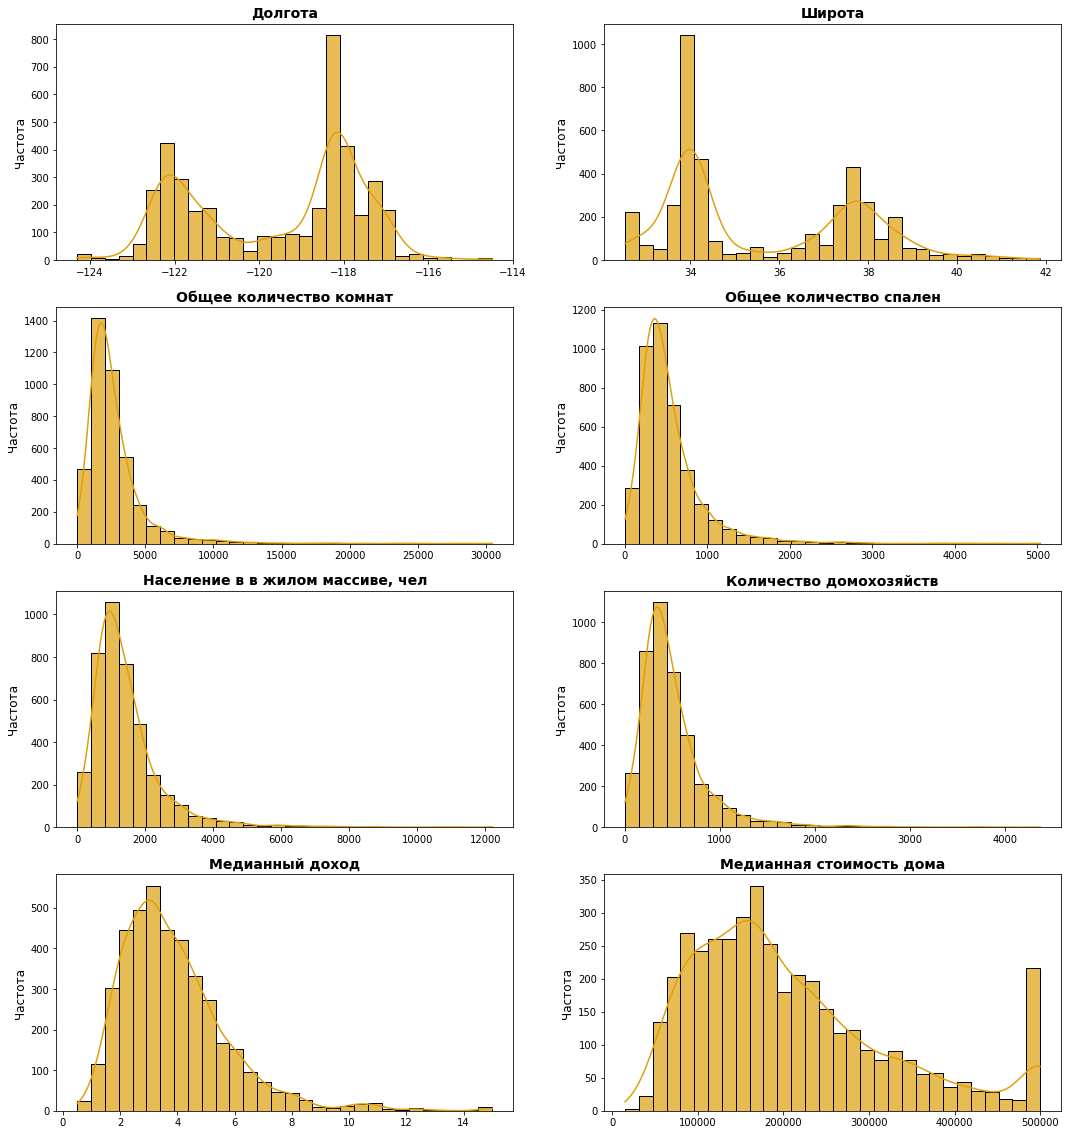

In [22]:
fig, axes = plt.subplots(4, 2, figsize=(18, 20))
axes = axes.flatten()

for i, col in enumerate(continuous_cols):
    # гистограмма с KDE
    sns.histplot(data=pdf, x=col, ax=axes[i], color='#DDA00D', kde=True, alpha=0.7, bins=30)
   
    axes[i].set_title(russian_names.get(col, col), fontsize=14, fontweight='bold')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Частота', fontsize=12)
plt.show()

Визуализируем распределения количественных показателей: дискретные признаки

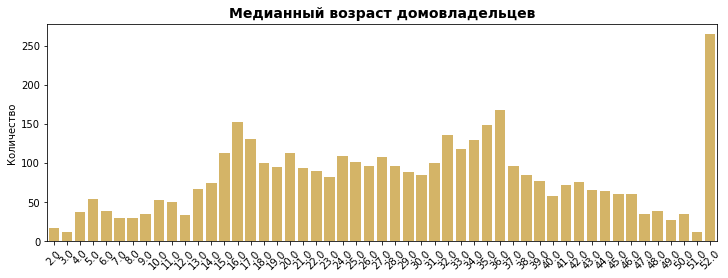

In [23]:
fig, axes = plt.subplots(1, len(discrete_cols), figsize=(12, 4))

# если только один график(как в нашем случае), превращаем axes в список
if len(discrete_cols) == 1:
    axes = [axes]

for i, col in enumerate(discrete_cols):
    sns.countplot(data=pdf, x=col, ax=axes[i], color='#DDA00D', alpha=0.7)
    axes[i].set_title(russian_names[col], fontsize=14, fontweight='bold')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Количество')
    axes[i].tick_params(axis='x', rotation=45)
plt.show()

**Анализ выбросов методами PySpark**

In [24]:
# все количественные признаки
num_cols = ['longitude', 'latitude', 'total_rooms', 'total_bedrooms', 'population',
                   'households', 'median_income', 'median_house_value', 'housing_median_age']

In [25]:
for col in num_cols:
    quantiles = df_housing.approxQuantile(col, [0.01, 0.25, 0.5, 0.75, 0.99], 0.01)
    print(f"{col}:  1%={quantiles[0]:.2f}, \
    Q1={quantiles[1]:.2f}, \
    Медиана={quantiles[2]:.2f}, \
    Q3={quantiles[3]:.2f}, \
    99%={quantiles[4]:.2f}")

longitude:  1%=-124.35,     Q1=-121.79,     Медиана=-118.52,     Q3=-118.03,     99%=-114.31
latitude:  1%=32.54,     Q1=33.93,     Медиана=34.24,     Q3=37.69,     99%=41.95
total_rooms:  1%=2.00,     Q1=1452.00,     Медиана=2114.00,     Q3=3105.00,     99%=39320.00
total_bedrooms:  1%=1.00,     Q1=298.00,     Медиана=433.00,     Q3=635.00,     99%=6445.00
population:  1%=3.00,     Q1=789.00,     Медиана=1159.00,     Q3=1700.00,     99%=35682.00
households:  1%=1.00,     Q1=281.00,     Медиана=407.00,     Q3=596.00,     99%=6082.00
median_income:  1%=0.50,     Q1=2.57,     Медиана=3.52,     Q3=4.70,     99%=15.00
median_house_value:  1%=14999.00,     Q1=120100.00,     Медиана=178600.00,     Q3=261500.00,     99%=500001.00
housing_median_age:  1%=1.00,     Q1=18.00,     Медиана=29.00,     Q3=37.00,     99%=52.00


**Анализ выбросов по межквартильному размаху:** 

* `longitude` (долгота). Значения в пределах 1% (-124.35) и 99% (-114.31) находятся в границах выбросов - выбросов нет
* `latitude` (широта). 99% перцентиль (41.95) близок к верхней границе - возможны незначительные выбросы
* `total_rooms` (общее количество комнат). 99% перцентиль (39320) значительно превышает верхнюю границу - сильные выбросы
* `total_bedrooms` (общее количество спален).  99% перцентиль (6445) сильно превышает границу - очень сильные выбросы
* `population` (население). 99% перцентиль (35682) значительно выше границы - сильные выбросы
* `households` (домашние хозяйства). 99% перцентиль (6082) сильно превышает границу - очень сильные выбросы
* `median_income` (медианный доход). 99% перцентиль (15.00) значительно выше границы - сильные выбросы
* `median_house_value` (медианная стоимость дома).  99% перцентиль (500001) превышает верхнюю границу - выбросы присутствуют
* `housing_median_age` (медиан.возраст). 99% перцентиль (52.00)  находится ниже верхней границы (65.50) - нет выбросов.

Рекомендации: устранить проблемы с выбросами по признакам `total_rooms, total_bedrooms, population, households, median_income, median_house_value`, т.к. могут плохо влиять на модели машинного обучения.

Для Сильно скошенных графиков используем логорифмирование из `pyspark`: `total_rooms, total_bedrooms, population, households`:

In [26]:
# логарифмирование к трен. данным
train_data_processed = train_data_encoded.withColumn("log_total_rooms", F.log(F.col("total_rooms") + 1))
train_data_processed = train_data_processed.withColumn("log_total_bedrooms", F.log(F.col("total_bedrooms") + 1))
train_data_processed = train_data_processed.withColumn("log_population", F.log(F.col("population") + 1))
train_data_processed = train_data_processed.withColumn("log_households", F.log(F.col("households") + 1))

# логарифмирование к тест. данным 
test_data_processed = test_data_encoded.withColumn("log_total_rooms", F.log(F.col("total_rooms") + 1))
test_data_processed = test_data_processed.withColumn("log_total_bedrooms", F.log(F.col("total_bedrooms") + 1))
test_data_processed = test_data_processed.withColumn("log_population", F.log(F.col("population") + 1))
test_data_processed = test_data_processed.withColumn("log_households", F.log(F.col("households") + 1))

**Корреляционный анализ**

Проведем анализ методом преобразования столбцов в векторы в PySpark - VectorAssembler:

In [27]:
def plot_correlation_matrix(df, num_cols): #создадим функцию для коррр.матрицы
    # создаем вектор признаков для корреляции
    assembler = VectorAssembler(inputCols=num_cols, outputCol='features')
    df_vector = assembler.transform(df).select('features')

    # вычисляем корреляцию
    correlation_matrix = Correlation.corr(df_vector, 'features').head()
    corr_array = correlation_matrix[0].toArray()

    # визуализация корр. матрицы
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_array, annot=True, fmt='.2f', xticklabels=num_cols, 
                yticklabels=num_cols, cmap='coolwarm', center=0)
    plt.title('Матрица корреляций количественных признаков')
    plt.xticks(rotation=45)
    plt.show()

25/11/30 00:09:57 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
25/11/30 00:09:57 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


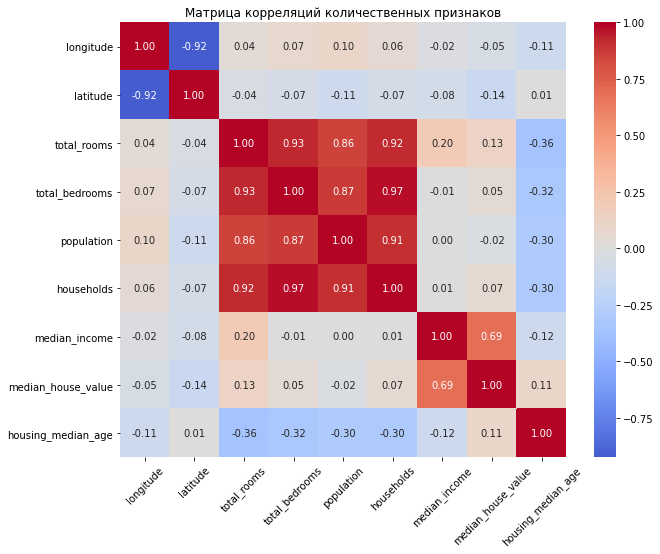

In [28]:
plot_correlation_matrix(df_housing, num_cols)

**Вывод по матрице корреляций признаков**

Пары признаков с высокой корреляцией (>0.9):
  * `longitude` - `latitude`: -0.92 - очень сильная отрицательная корреляция
  * `total_rooms` - `total_bedrooms`: 0.93
  * `total_rooms` - `households`: 0.92
  * `total_bedrooms` - `households`: 0.97
  * `population` - `households`: 0.91
    
Умеренные корреляции (0.5 < корр. < 0.9):
  * `median_income` и `median_house_value`: 0.69 положительная
  * `total_rooms` и `population`: 0.86
  * `total_bedrooms` и `population`: 0.87

Слабые корреляции (< 0.5): все остальные пары.

Рекомендация для моделирования:
1. точно оставить `median_income`, так как доход по всей видимости определяет стоимость дома и он сильнее всего связан с целевой переменной.
2. можно удалить `total_bedrooms`, он сильно дублирует информацию
3. создать новые признаки вместо сильно коррелирующих

In [29]:
# вместо удаления создаем осмысленные производные признаки к тренировочным данным
train_data_final = train_data_processed.withColumn(
    'rooms_per_household', F.col('total_rooms') / F.col('households')).withColumn(
    'bedrooms_ratio', F.when(F.col('total_rooms') == 0, 0).otherwise(
        F.col('total_bedrooms') / F.col('total_rooms'))).withColumn(
    'population_per_household', F.col('population') / F.col('households')).withColumn(
    'income_per_room', F.when(F.col('total_rooms') == 0, 0).otherwise(
        F.col('median_income') / F.col('total_rooms')))

# удалим исходные сильно коррелирующие признаки из тренировочных данных
cols_to_drop = ['total_bedrooms', 'households']
train_data_final = train_data_final.drop(*cols_to_drop)

In [30]:
# добавим признаки (те же)  к тестовым данным
test_data_final = test_data_processed.withColumn(
    'rooms_per_household', F.col('total_rooms') / F.col('households')).withColumn(
    'bedrooms_ratio', F.when(F.col('total_rooms') == 0, 0).otherwise(
        F.col('total_bedrooms') / F.col('total_rooms'))).withColumn(
    'population_per_household', F.col('population') / F.col('households')).withColumn(
    'income_per_room', F.when(F.col('total_rooms') == 0, 0).otherwise(
        F.col('median_income') / F.col('total_rooms')))

# удаляем те же признаки из тестовых данных
test_data_final = test_data_final.drop(*cols_to_drop)

In [31]:
num_cols_new = [
    'longitude', 'latitude', 
    'log_total_rooms', 'log_population',  # используем логарифмированные
    'median_income', 'median_house_value', 'housing_median_age',
    'rooms_per_household', 'bedrooms_ratio', 'population_per_household', 'income_per_room']

Выполним корреляционный анализ с новыми фичами только на тренировочных данных, а тестовые данные должны оставаться  до финальной оценки моделей:

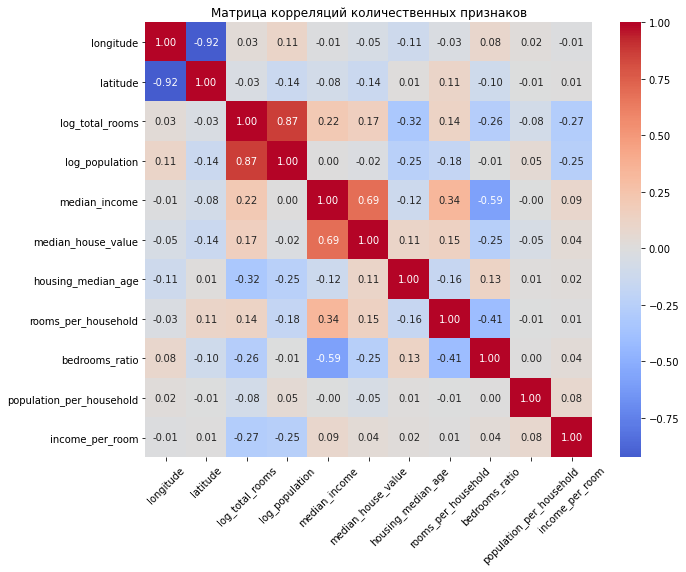

In [32]:
# проверим корреляциии на вновь созданных признаках
plot_correlation_matrix(train_data_final, num_cols_new)

**Вывод по корреляции новых признаков:**


Мы устранили все проблемные корреляции (>0.9) между признаками:
* было: `total_rooms` и `total_bedrooms` (0.93), `total_bedrooms` и `households` (0.97)
* стало: максимальная корреляция 0.86 (`log_total_rooms` и `log_population`)
* `широту` и `долготу` с корреляцией оставляем как есть,т.к. высокая корреляция между широтой и долготой (-0.92) - это нормально и ожидаемо. Это координаты, они должны таким образом коррелировать и определять местоположение.

Итог модификации и удаления признаков:
* `median_income` и `median_house_value` (0.69) - самая важная для прогнозирования пара сохранена
* уменьшена мультиколлинеарность между признаками
* созданы осмысленные производные признаки

**Анализ категориальных переменных**

Визуализируем распределения количественных показателей: категориальные признаки

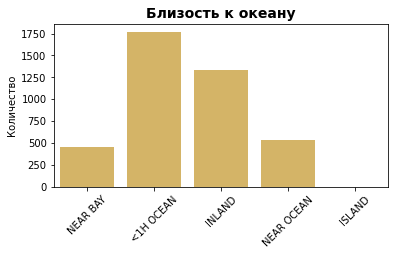

In [33]:
# отдельная ось для каждой категориальной переменной
fig, axes = plt.subplots(len(categorical_cols), 1, figsize=(6, 3 * len(categorical_cols)))

# если одна ось(как у нас), превращаем в список для единообразия
if len(categorical_cols) == 1:
    axes = [axes]

for i, col in enumerate(categorical_cols):
    sns.countplot(data=pdf, x=col, ax=axes[i], color='#DDA00D', alpha=0.7)  
    axes[i].set_title(russian_names[col], fontsize=14, fontweight='bold')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Количество')
    axes[i].tick_params(axis='x', rotation=45)
plt.show()

Проведем анализ категориального признака `ocean_proximity` методами PySpark:

In [34]:
ocean_stats = df_housing.groupBy('ocean_proximity').agg(
    F.count('*').alias('count'),
    F.avg('median_house_value').alias('avg_house_value'),
    F.avg('median_income').alias('avg_income')).orderBy('count', ascending=False)
ocean_stats.show()

+---------------+-----+------------------+------------------+
|ocean_proximity|count|   avg_house_value|        avg_income|
+---------------+-----+------------------+------------------+
|      <1H OCEAN| 9136|240084.28546409807|4.2306819176882655|
|         INLAND| 6551|124805.39200122119| 3.208996382231716|
|     NEAR OCEAN| 2658|249433.97742663656| 4.005784800601957|
|       NEAR BAY| 2290|259212.31179039303| 4.172884759825336|
|         ISLAND|    5|          380440.0|2.7444200000000003|
+---------------+-----+------------------+------------------+



**Вывод по анализу категориальных признаков**

* Большинство районов расположены в зоне <1H OCEAN  = 9136.
* Наименьшее количество в ISLAND  - всего лишь 5.
* Самая высокая стоимость в ISLAND = 380,440, но сама  выборка очень мала по данному району
* Высокая стоимость в NEAR BAY = 259,212 и NEAR OCEAN = 249,434.
* Низкая стоимость в INLAND 124,805  - это больше в 2 раза дешевле, чем в дорогих районах.
* Более высокие доходы у людей в прибрежных зонах
* Самый низкий доход в INLAND = 3.21 и ISLAND = 2.74.

Локация - это ключевой фактор ценообразования, значит, `ocean_proximity` как важный категориальный признак

Географический анализ цен на дома в зависимости от широты и долготы:

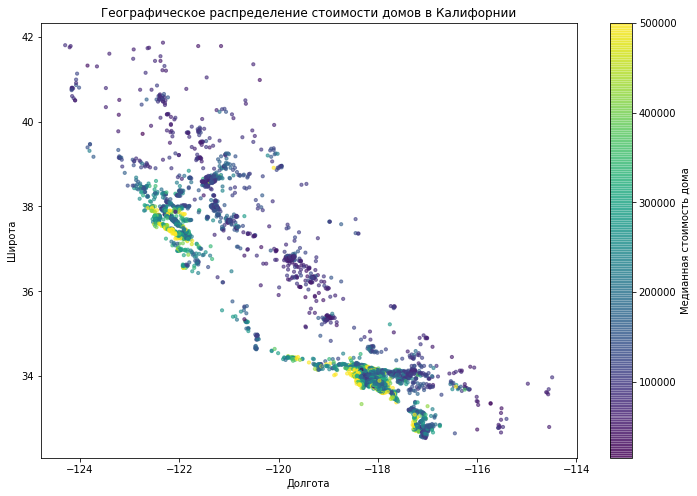

In [35]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(pdf['longitude'], pdf['latitude'], 
                     c=pdf['median_house_value'], 
                     cmap='viridis', alpha=0.6, s=10)
plt.colorbar(scatter, label='Медианная стоимость дома')
plt.xlabel('Долгота')
plt.ylabel('Широта')
plt.title('Географическое распределение стоимости домов в Калифорнии')
plt.show()

**Географический анализ цен на дома**

Ценвые кластеры:

* Высокие цены (желтые точки) - это районы Сан-Франциско (-122, 37.7) и Лос-Анджелеса (-118, 34)
* Средние цены (зеленые) - это прибрежные зоны 
* Низкие цены (фиолетовые) - это внутренние районы и, возможно, сельская местность (INLAND)


Выводы:
Локация = цена: географическое положение определяет стоимость, близость к океану добавляет ценность.

Рекомендуется использовать долготу и широту как важные признаки в модели, возможно с созданием признаков расстояния до побережья.

**Вывод по исследовательскому анализу данных:**

В ходе комплексного анализа количественных и категориальных признаков в выборке было выполнено:
1. Анализ количественнных переменных:
  * визуализация распределения количественных показателей: непрерывные признаки
  * визуализация распределения количественных показателей: дискретные признаки
  * анализ выбросов количественных признаков методами PySpark и решена проблема сильных выбросов без потери информации
  * корреляционный анализ - анализ методом преобразования столбцов в векторы в PySpark:
    1) устранены корреляции >0.9 между размерами домов
    2) созданы новые признаки путем логорифмирования: `rooms_per_household, bedrooms_ratio, population_per_household, income_per_room`
    3) удалены самые коррелирующие признаки: total_bedrooms, households
2. Анализ категориальных переменных:
  * визуализация распределения категориальных показателей: категориальные признаки
  * анализ распределения категориальных показателей методами PySpark
3. Географический анализ цен на дома в зависимости от широты и долготы: построен график скаттер - зависимости цен от разных удаленных районов

Итоги: 

* Главный фактор ценообразования это  `median_income` (корреляция 0.69)
* Прибрежные зоны дороже внутренних в 2 раза и более
* `ocean_proximity` - также важный категориальный признак ценнобразования
* сохранена географическая информация (широта и долгота) даже с высокой обратной корреляцией.

## Построение моделей линейной регрессии 

### Трансформация категориальных признаков и их сбор с помощью VectorAssembler (для one-hot encoded)

Для трансформация категорийных признаков ранее мы использовали `StringIndexer` и `OneHotEncoder` для индексированной колонки. А также мы уже разделили данные на train и test, и теперь у нас есть `train_data_final` и `test_data_final`.


Теперь сделаем финальный шаг преобразований для - это объединение признаков в один вектор с помощью `VectorAssembler`, с которым ML-алгоритм будет работать (применим к тест- и трейн- датафреймам отдельно):

In [36]:
# VectorAssembler для one-hot encoded признаков
categorical_assembler = VectorAssembler(
    inputCols=['ocean_proximity_ohe'], outputCol="categorical_features")
# к тренировочным данным
train_data_final = categorical_assembler.transform(train_data_final)

# к тестовым данным
test_data_final = categorical_assembler.transform(test_data_final)

# показываем результат
train_data_final.select(
    'ocean_proximity', 'ocean_proximity_idx', 'ocean_proximity_ohe', 'categorical_features').show(5)
test_data_final.select(
    'ocean_proximity', 'ocean_proximity_idx', 'ocean_proximity_ohe', 'categorical_features').show(5)

+---------------+-------------------+-------------------+--------------------+
|ocean_proximity|ocean_proximity_idx|ocean_proximity_ohe|categorical_features|
+---------------+-------------------+-------------------+--------------------+
|     NEAR OCEAN|                2.0|      (5,[2],[1.0])|       (5,[2],[1.0])|
|     NEAR OCEAN|                2.0|      (5,[2],[1.0])|       (5,[2],[1.0])|
|     NEAR OCEAN|                2.0|      (5,[2],[1.0])|       (5,[2],[1.0])|
|     NEAR OCEAN|                2.0|      (5,[2],[1.0])|       (5,[2],[1.0])|
|     NEAR OCEAN|                2.0|      (5,[2],[1.0])|       (5,[2],[1.0])|
+---------------+-------------------+-------------------+--------------------+
only showing top 5 rows

+---------------+-------------------+-------------------+--------------------+
|ocean_proximity|ocean_proximity_idx|ocean_proximity_ohe|categorical_features|
+---------------+-------------------+-------------------+--------------------+
|     NEAR OCEAN|          

### Трансформация числовых признаков с помощью StandardScaler. 

Шкалируем признаки для приведения к единому масштабу, список числовых признаков лежит в `num_cols_new`:

In [37]:
# убираем целевую переменную из списка признаков
target = 'median_house_value' # оставим ее строкой
num_cols_no_target = [col for col in num_cols_new if col != target]

assembler = VectorAssembler(inputCols=num_cols_no_target, outputCol='numerical_features')

# применим assembler к тренировочным данным
train_data_final = assembler.transform(train_data_final)
# применим assembler к тестовым данным  
test_data_final = assembler.transform(test_data_final)

# StandardScaler обучаем только на тренировочных данных
scaler = StandardScaler(inputCol='numerical_features', outputCol='numerical_scaled_features')
scaler_model = scaler.fit(train_data_final)  # fit толко на train

# применим обученный scaler к трен.данным и тест.данным
train_data_final = scaler_model.transform(train_data_final)
test_data_final = scaler_model.transform(test_data_final)

In [38]:
# проверяем результат после трансформации
print(train_data_final.columns)
print(test_data_final.columns)

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'population', 'median_income', 'median_house_value', 'ocean_proximity', 'ocean_proximity_idx', 'ocean_proximity_ohe', 'log_total_rooms', 'log_total_bedrooms', 'log_population', 'log_households', 'rooms_per_household', 'bedrooms_ratio', 'population_per_household', 'income_per_room', 'categorical_features', 'numerical_features', 'numerical_scaled_features']
['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'population', 'median_income', 'median_house_value', 'ocean_proximity', 'ocean_proximity_idx', 'ocean_proximity_ohe', 'log_total_rooms', 'log_total_bedrooms', 'log_population', 'log_households', 'rooms_per_household', 'bedrooms_ratio', 'population_per_household', 'income_per_room', 'categorical_features', 'numerical_features', 'numerical_scaled_features']


### Сбор трансформированных категорийных и числовых признаков с помощью VectorAssembler

In [39]:
all_features = ['categorical_features', 'numerical_scaled_features']

final_assembler = VectorAssembler(inputCols=all_features, outputCol='features')

# применим к трен.данным и тест.данным
train_data_final = final_assembler.transform(train_data_final)
test_data_final = final_assembler.transform(test_data_final)

### Разделение датасета на выборки (для двух наборов данных) 

#### Набор данных № 1: все данные из файла (и числовые и категориальные признаки) 

У нас уже есть `train_data_final` и `test_data_final` с колонкой `features`:

In [40]:
print(f"Набор 1: train - {train_data_final.count()}, test - {test_data_final.count()}")

Набор 1: train - 16454, test - 4186


#### Набор данных № 2: используем только числовые переменные, исключив категориальные. 

Также разделение на выборки в Spark сделаем с помощью метода `randomSplit()` и `VectorAssembler` предварительно создав новый вектор:

In [41]:
# создаем новый вектор только с числовыми признаками
numerical_features_only = ['numerical_scaled_features']  # используем уже отшкалированные числовые признаки

final_assembler_num = VectorAssembler(
    inputCols=numerical_features_only,
    outputCol='features_numerical_only')

# применим к трен. и тест. данным
train_data_num = final_assembler_num.transform(train_data_final)
test_data_num = final_assembler_num.transform(test_data_final)

In [42]:
#  2-й набор
print(f"Набор 2: train - {train_data_num.count()}, test - {test_data_num.count()}")

Набор 2: train - 16454, test - 4186


### Обучение моделей на разных данных

Для построения моделей используем оценщик `LinearRegression` из библиотеки `MLlib`.

#### Набор данных № 1: 

In [43]:
lr_1 = LinearRegression(labelCol=target, featuresCol='features')
model_1 = lr_1.fit(train_data_final)

25/11/30 00:10:11 WARN Instrumentation: [91d6fa1a] regParam is zero, which might cause numerical instability and overfitting.
25/11/30 00:10:12 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
25/11/30 00:10:12 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
25/11/30 00:10:12 WARN Instrumentation: [91d6fa1a] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


#### Набор данных № 2: 

In [44]:
lr_2 = LinearRegression(labelCol=target, featuresCol='features_numerical_only')
model_2 = lr_2.fit(train_data_num)

25/11/30 00:10:14 WARN Instrumentation: [5e363a87] regParam is zero, which might cause numerical instability and overfitting.


### Предсказание на тестовых данных на разных выборках

#### Набор данных № 1: 

In [45]:
predictions_1 = model_1.transform(test_data_final)

predictions_1.select('median_house_value', 'prediction').show(10)

+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|          103600.0|139406.44015902188|
|          106700.0|210762.37855165824|
|          107000.0|176303.47400081204|
|          116100.0|220100.09382209787|
|           85600.0|179274.45764464745|
|           81800.0| 231121.2665293808|
|           76900.0|164578.21510119643|
|           74100.0|    156708.2725958|
|           96000.0|160013.63455992984|
|           75500.0|120408.94591158349|
+------------------+------------------+
only showing top 10 rows



#### Набор данных № 2: 

In [46]:
predictions_2 = model_2.transform(test_data_num)

predictions_2.select('median_house_value', 'prediction').show(10)

+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|          103600.0| 99439.74778517522|
|          106700.0|190568.00701770373|
|          107000.0|153112.63874650374|
|          116100.0|194674.84712426318|
|           85600.0|154275.30801600404|
|           81800.0| 206924.9958522697|
|           76900.0|139509.87074307445|
|           74100.0|133560.40972766373|
|           96000.0|131195.12594790803|
|           75500.0| 90812.25001913123|
+------------------+------------------+
only showing top 10 rows



## Оценка качества работы линейной регрессии (сравнение на двух наборах данных).

Сравним работу моделей по метрикам `RMSE`, `MAE` и `R2`. Качество алгоритмов классификации оценним, используя трансформер
`RegressionEvaluator`:

In [47]:
# cоздаем RegressionEvaluator для `RMSE`, `MAE` и `R2`
evaluator_rmse = RegressionEvaluator(
    labelCol='median_house_value', 
    predictionCol='prediction', 
    metricName='rmse')

evaluator_mae = RegressionEvaluator(
    labelCol='median_house_value', 
    predictionCol='prediction', 
    metricName='mae')

evaluator_r2 = RegressionEvaluator(
    labelCol='median_house_value', 
    predictionCol='prediction', 
    metricName='r2')

In [48]:
# оценка качества для модели 1 
rmse_1 = evaluator_rmse.evaluate(predictions_1)
mae_1 = evaluator_mae.evaluate(predictions_1)
r2_1 = evaluator_r2.evaluate(predictions_1)

In [49]:
# оценка качества для модели 2 (только числовые признаки)
rmse_2 = evaluator_rmse.evaluate(predictions_2)
mae_2 = evaluator_mae.evaluate(predictions_2)
r2_2 = evaluator_r2.evaluate(predictions_2)

In [50]:
# выведем результаты сравнения
print(f"{'Метрика':<10} | {'Модель 1':<20} | {'Модель 2 ':<20}")
print(f"{'RMSE':<10} | {rmse_1:<20.2f} | {rmse_2:<20.2f}")
print(f"{'MAE':<10} | {mae_1:<20.2f} | {mae_2:<20.2f}")
print(f"{'R2':<10} | {r2_1:<20.4f} | {r2_2:<20.4f}")

Метрика    | Модель 1             | Модель 2            
RMSE       | 73837.15             | 75283.91            
MAE        | 49833.58             | 50519.95            
R2         | 0.5920               | 0.5759              


**Вывод**

* Модель 1 лучше, то есть категориальные признаки добавляют ценность (R2= 0.5920 у первой, и R2 = 0.5759 у второй)
* Стоимость домов от 15000 до 500 0000 и более, поэтому ошибки в 50-70K - это  примерно 20-30% от средней цены, это значительная ошибка.
* R² = 0.59 (наибольшая), то есть модель объясняет 59% вариативности цен - неплохо для 1 итерации.


Дальнейший палн работы по улучшению качества моделей:

1) создать новые признаки по взаимодействию, по удаленности к предрежной зоне, например. Сделать доход по корзинкам и далее использовать StringIndexer() и OneHotEncoder() для кодировки признака
2) пересобрать все новые и старые признаки вместе с помощью VectorAssembler(
3) разделить снова на train/test новый набор признаков
4) использовать более сложные модели - Random Forest и Gradient Boosting с улучшенными признаками
5) создать новые evaluator и сделать оценка качества поделей по ним


## Улучшение качества моделей (вторая итерация)

Добавим 3 новых признаков в финальный вектор `features` на тренировочных данных и отдельно для тестовых:

In [51]:
# пространственные признаки ТРЕН
train_data_enhanced = train_data_final.withColumn(
    "distance_to_coast", F.sqrt(F.col("longitude")**2 + F.col("latitude")**2)).withColumn(
    "is_coastal", F.when(F.col("ocean_proximity").isin(["NEAR BAY", "<1H OCEAN", "NEAR OCEAN"]), 1).otherwise(0))

# взаимодействие признаков ТРЕН
train_data_enhanced = train_data_enhanced.withColumn(
    "income_per_person", F.col("median_income") / (F.col("population") + 1)).withColumn(
    "rooms_per_person", F.col("total_rooms") / (F.col("population") + 1))

# биннинг непрерывных переменных ТРЕН
train_data_enhanced = train_data_enhanced.withColumn(
    "income_bucket",
    F.when(F.col("median_income") < 2, "low")
     .when(F.col("median_income") < 4, "medium")
     .when(F.col("median_income") < 6, "high")
     .otherwise("very_high"))

In [52]:
# пространственные признаки ТЕСТ
test_data_enhanced = test_data_final.withColumn(
    "distance_to_coast", F.sqrt(F.col("longitude")**2 + F.col("latitude")**2)).withColumn(
    "is_coastal", F.when(F.col("ocean_proximity").isin(["NEAR BAY", "<1H OCEAN", "NEAR OCEAN"]), 1).otherwise(0))

# взаимодействие признаков ТЕСТ
test_data_enhanced = test_data_enhanced.withColumn(
    "income_per_person", F.col("median_income") / (F.col("population") + 1)).withColumn(
    "rooms_per_person", F.col("total_rooms") / (F.col("population") + 1))

# биннинг непрерывных переменных ТЕСТ
test_data_enhanced = test_data_enhanced.withColumn(
    "income_bucket",
    F.when(F.col("median_income") < 2, "low")
     .when(F.col("median_income") < 4, "medium")
     .when(F.col("median_income") < 6, "high")
     .otherwise("very_high"))

Сначала обработаем новый категориальный признак `income_bucket`(нужно применить StringIndexer и OneHotEncoder для нового признака income_bucket к обоим датафреймам (тест. и трен.), но обучать только на тренировочных данных:

In [53]:
# индексы
income_indexer = StringIndexer(inputCol='income_bucket',
                               outputCol='income_bucket_idx')

income_indexer_model = income_indexer.fit(train_data_enhanced)  #  fit только на train

# transform применим к трен. и тест. данным
train_data_enhanced = income_indexer_model.transform(train_data_enhanced)
test_data_enhanced = income_indexer_model.transform(test_data_enhanced)

# OneHotEncoder для income_bucket обучаем на тренировочных данных
income_encoder = OneHotEncoder(
    inputCols=['income_bucket_idx'],
    outputCols=['income_bucket_ohe'])

income_encoder_model = income_encoder.fit(train_data_enhanced)  #  fit только на train

# применим к трен.и тест. данным
train_data_enhanced = income_encoder_model.transform(train_data_enhanced)
test_data_enhanced = income_encoder_model.transform(test_data_enhanced)

25/11/30 00:10:20 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Создаем новый `VectorAssembler` со всеми признаками:

In [54]:
final_assembler_enhanced = VectorAssembler(
    inputCols=[
        'numerical_scaled_features',  # исходные числовые признаки
        'categorical_features',       # исходные категориальные (ocean_proximity)
        'income_bucket_ohe',          # новые категориальные
        'distance_to_coast',          # новые числовые
        'is_coastal',                 # новые числовые
        'income_per_person',          # новые числовые
        'rooms_per_person'],          # новые числовые
    outputCol='features_enhanced')

Теперь применим финальный VectorAssembler к обоим выборкам отдельно `train` и `test`:

In [55]:
# применяем к трен. и тест. данным
train_data_enhanced = final_assembler_enhanced.transform(train_data_enhanced)
test_data_enhanced = final_assembler_enhanced.transform(test_data_enhanced)

Обучаем модели, выбираем более сложные модели `RandomForestRegressor` и `Gradient Boosting`:

In [56]:
rf_enhanced = RandomForestRegressor(
    labelCol='median_house_value',
    featuresCol='features_enhanced',  # тут используем новые признаки
    numTrees=100,
    maxDepth=10,
    seed=RANDOM_SEED,
    predictionCol='prediction_rf_enhanced')

rf_model_enhanced = rf_enhanced.fit(train_data_enhanced)

25/11/30 00:10:30 WARN DAGScheduler: Broadcasting large task binary with size 1109.2 KiB
25/11/30 00:10:32 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/11/30 00:10:36 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
25/11/30 00:10:38 WARN DAGScheduler: Broadcasting large task binary with size 1066.2 KiB
25/11/30 00:10:40 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
25/11/30 00:10:43 WARN DAGScheduler: Broadcasting large task binary with size 1806.0 KiB
25/11/30 00:10:46 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB
25/11/30 00:10:50 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


In [57]:
gbt_enhanced = GBTRegressor(
    labelCol='median_house_value',
    featuresCol='features_enhanced',  # используем новые признаки
    maxIter=100,
    maxDepth=5,
    seed=RANDOM_SEED,
    predictionCol='prediction_gbt_enhanced')

gbt_model_enhanced = gbt_enhanced.fit(train_data_enhanced)

Создаем `RegressionEvaluator` с правильными именами столбцов предсказаний (так как теперь предсказания находятся в столбцах `prediction_rf_enhanced` и `prediction_gbt_enhanced`)

In [58]:
evaluator_rmse_rf = RegressionEvaluator(
    labelCol='median_house_value', 
    predictionCol='prediction_rf_enhanced', 
    metricName='rmse')

evaluator_r2_rf = RegressionEvaluator(
    labelCol='median_house_value', 
    predictionCol='prediction_rf_enhanced',
    metricName='r2')

evaluator_rmse_gbt = RegressionEvaluator(
    labelCol='median_house_value', 
    predictionCol='prediction_gbt_enhanced', 
    metricName='rmse')

evaluator_r2_gbt = RegressionEvaluator(
    labelCol='median_house_value', 
    predictionCol='prediction_gbt_enhanced',
    metricName='r2')

Предсказания для новых моделей:

In [59]:
predictions_rf_enhanced = rf_model_enhanced.transform(test_data_enhanced)
predictions_gbt_enhanced = gbt_model_enhanced.transform(test_data_enhanced)

Оценка качества новых моделей:

In [60]:
rmse_rf_enhanced = evaluator_rmse_rf.evaluate(predictions_rf_enhanced)
r2_rf_enhanced = evaluator_r2_rf.evaluate(predictions_rf_enhanced)

rmse_gbt_enhanced = evaluator_rmse_gbt.evaluate(predictions_gbt_enhanced)
r2_gbt_enhanced = evaluator_r2_gbt.evaluate(predictions_gbt_enhanced)

In [61]:
print("Сравнение всех моделей:")
print(f"{'Модель':<25} | {'RMSE':<10} | {'R2':<10} | {'Улучшение R2':<15}")
print(f"{'Linear (все признаки)':<25} | {rmse_1:<10.0f} | {r2_1:<10.4f} | {'-':<15}")
print(f"{'Linear (только числ.)':<25} | {rmse_2:<10.0f} | {r2_2:<10.4f} | {'-':<15}")
print(f"{'Random Forest':<25} | {rmse_rf_enhanced:<10.0f} | {r2_rf_enhanced:<10.4f} | {r2_rf_enhanced - r2_1:>+6.4f}")
print(f"{'Gradient Boosting':<25} | {rmse_gbt_enhanced:<10.0f} | {r2_gbt_enhanced:<10.4f} | {r2_gbt_enhanced - r2_1:>+6.4f}")

Сравнение всех моделей:
Модель                    | RMSE       | R2         | Улучшение R2   
Linear (все признаки)     | 73837      | 0.5920     | -              
Linear (только числ.)     | 75284      | 0.5759     | -              
Random Forest             | 53875      | 0.7828     | +0.1908
Gradient Boosting         | 50222      | 0.8112     | +0.2192


In [62]:
# останавливаем Spark сессию для освобождения ресурсов
spark.stop()

**Вывод**

* Gradient Boosting  лучшая модель с R2 = 0.81
* Улучшение на 22% по сравнению с линейной регрессией
* Ошибка уменьшилась на треть: с 73837 до 50222, что явялется хорошим результатом.

Проведенная работа на этапе 2 итерации:
* создали новые признаки, в том числе с бинами
* использовали более сложные алгоритмы, в том числе ансамблевые
* оценили качество на тестовых данных
* сравнили все модели с базовыми

## Общий вывод

**Описание задач:**
* Изучение данных открытого источника с переписью населения 1990-го года штата Калифорния.  
* Разработка двух моделей линейной регрессии на разных наборах данных.
* Сравнение результатов работы линейной регрессии на двух наборах данных.

**Этапы работы:**

Исходные данные и проведённая обработка данных:
* для исследовании использовались данные открытого источника сс переписью населения 1990-го года штата Калифорния. 
* в ходе предобработки данных были проверены  и исправлены типы данных, дубликаты и пропущенные значения в датасетах для обоих датасетов.
* в ходе исследовательского анализа был проведен статистический анализ данных, построена матрица корреляции признаков.
 
Для поиска лучшей модели  2 задачи были:
* созданы новые признаки  и использованы `StringIndexer()` и `OneHotEncoder()` для кодировки категориального признака
* собраны все признаки вместе с помощью` VectorAssembler()`
* созданы 2 выборки и эти выборки разделены  на тренировочные и тестовые
* использованы  модели линейной регрессии с улучшенными признаками
* создать evaluator и произведена оценка качества поделей по ним
* для оценки качества модели были выбраны метрики `RMSE`, `MAE` и `R2`.

Наилучшей себя показала модель линейной регрессии, которая обучена с категориальными признаками. На 1-й итерации модель показала невысокую оценку `R2` = 59%. Также была предпринята 2 итерация по обучению моделей, где были добавлены новые признаки и использованы ансамблевые методы моделирования. Лучшей себя показала `Gradient Boosting` с `R2` = 0.8128. Улучшение превысило 22% по сравнению с линейной регрессией и 
ошибка уменьшилась на треть: с 73837 до 50009, что являлется хорошим результатом.

Ключевые наблюдения из анализа данных:
* география определяет цену, так как прибрежные районы в 2 раза дороже материковых
* доход людей это главный покзатель, так как корреляция `median_income` с ценой самая сильная
* категориальные признаки важны, так как `ocean_proximity`  улучшил качество моделей
* выбросы влияют на качество моделей, так как без логарифмирования качество моделей значительно ниже (`R2` на 2% примерно)


Применение в бизнесе:
* Модель может автоматизировать 80% рутинных оценок, так как точность в $50000 достаточна для первичной оценки недвижимости